In [ ]:
min_level_dB
min_level_dB_floor
spec_thresh_delta_dB
silence_threshold
frame_shift_ms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
import matplotlib
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
cmap.set_bad(color=(0,0,0,0))

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'european_starling_gentner'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

In [7]:
def norm(x, _type="zero_one"):
    return (x-np.min(x)) / (np.max(x)-np.min(x))

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    n_fft = 512,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 3,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    n_jobs = -1,
    verbosity=1,
    nex = 20
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    7.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.1s finished


In [10]:
# dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [267]:
figsize= (40, 5)

In [268]:
dataset.sample_json

OrderedDict([('species', 'Lonchura striata domestica'),
             ('common_name', 'Sturnus vulgaris'),
             ('indvs', OrderedDict([('b1160', OrderedDict())])),
             ('datetime', '2017-11-17_17-11-06'),
             ('samplerate_hz', 44100),
             ('length_s', 65.99),
             ('wav_loc',
              '/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav')])

In [269]:
len(dataset.data_files)

20

In [270]:
dataset.sample_json['wav_loc']

'/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav'

In [271]:
from avgn.utils.audio import load_wav

In [272]:
rate, data = load_wav(dataset.sample_json['wav_loc'])

In [273]:
data = data[rate*20:rate*30]

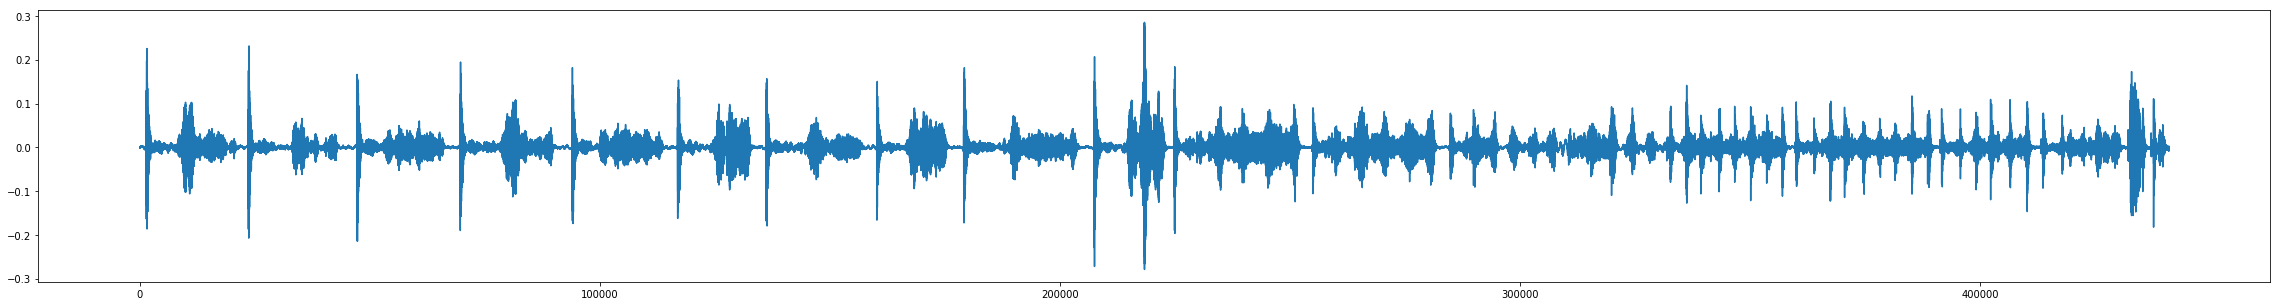

In [274]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data)

### Create spectrogram of data

In [471]:
from avgn.signalprocessing.spectrogramming import spectrogram
from noisereduce.noisereduce import convolve_gaussian, _smoothing_filter
from avgn.visualization.spectrogram import plot_spec

In [591]:
spec = spectrogram(data, rate, hparams)
np.shape(spec)

(257, 3341)

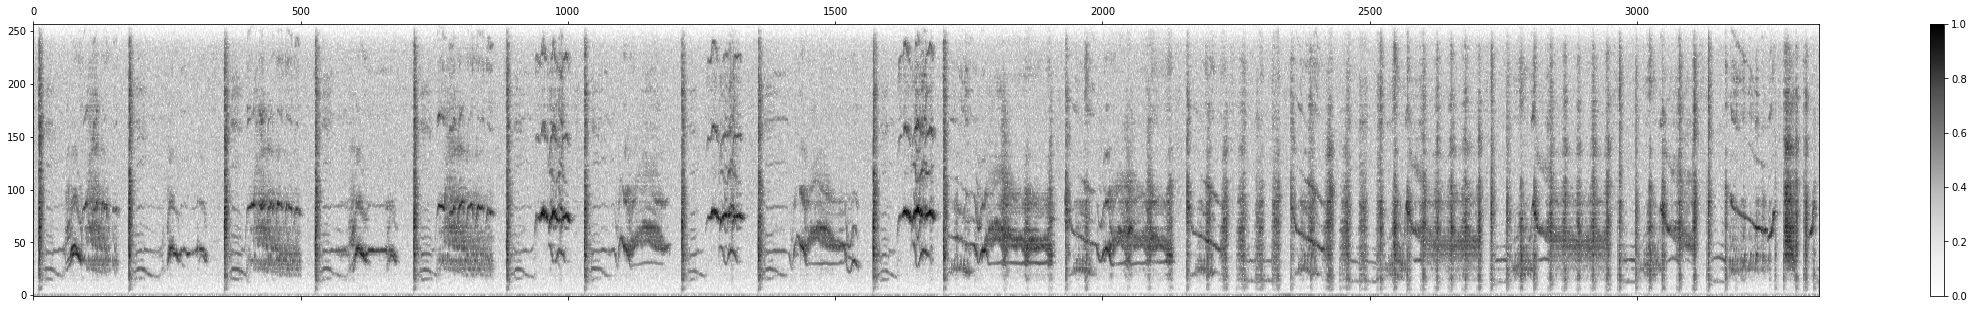

In [592]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(spec, fig = fig, ax=ax, cmap = plt.cm.Greys);

### create mask of spectrogram

In [593]:
n_std = .5

In [594]:
mask = spec.T
mask = (mask < (np.median(mask, axis=0) + n_std*np.std(mask, axis=0))).T.astype('float32')

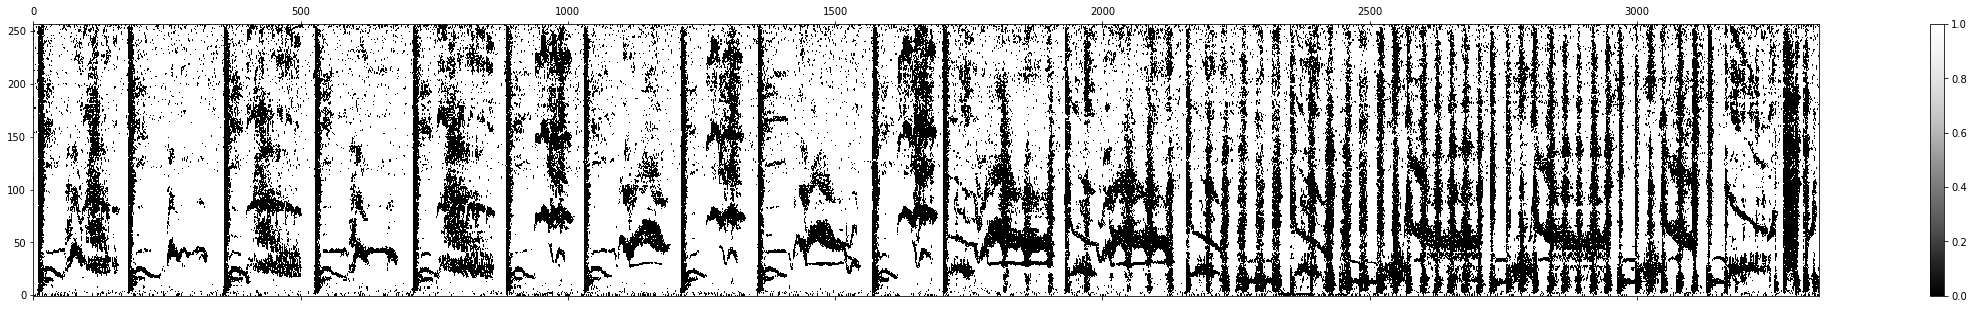

In [595]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(mask, fig = fig, ax=ax, cmap = plt.cm.Greys_r);

### remove non-continuous components of mask

In [596]:
import scipy.signal

In [597]:
time_grad_ms = 5
freq_grad_hz = 500
neighborhood_thresh = .5

n_grad_freq = int(freq_grad_hz / ((rate/2) / np.shape(mask)[0]))
n_grad_time = int(hparams.hop_length_ms * time_grad_ms)

In [598]:
# Create a smoothing filter for the mask in time and frequency
smoothing_filter = np.ones((n_grad_freq,n_grad_time))/np.product((n_grad_freq,n_grad_time))
np.shape(smoothing_filter)

(5, 15)

In [599]:
mask_mask = scipy.signal.fftconvolve((1-mask.astype('float32')), smoothing_filter, mode="same")
mask_mask = (mask_mask < neighborhood_thresh)

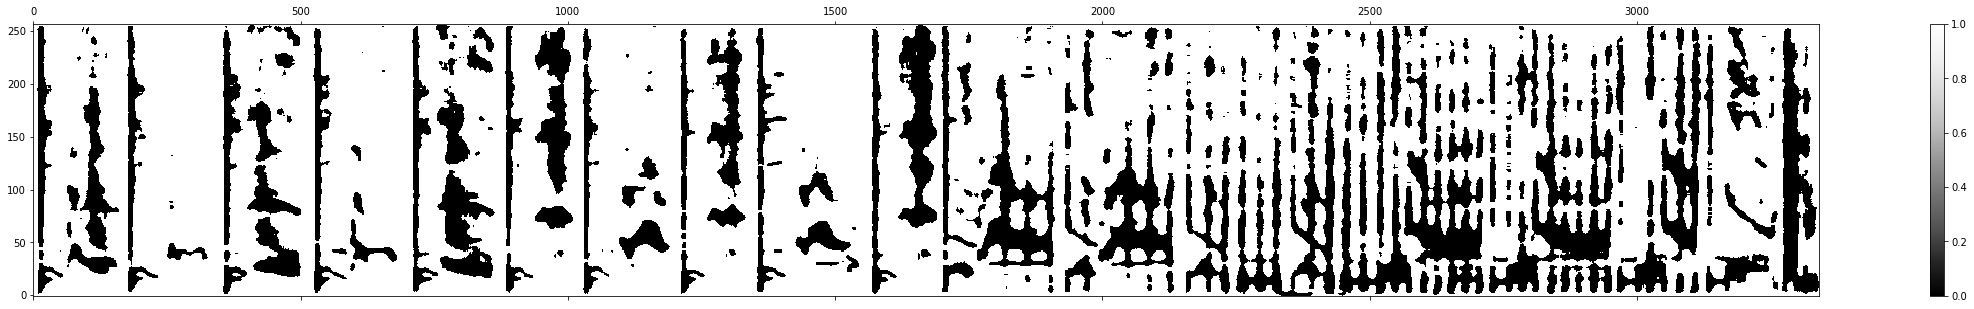

In [600]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(mask_mask.astype('float'), fig = fig, ax=ax, cmap = plt.cm.Greys_r);

### get clusters from map

In [590]:
from scipy import ndimage

In [557]:
blobs, number_of_blobs = ndimage.label(mask_mask == False)
blobs = np.ma.masked_where(blobs == 0, blobs)
blobs = np.array(blobs.data).astype('float32')
number_of_blobs

426

In [558]:
unique_pts = np.unique(blobs[blobs != 0].astype(int))
len(unique_pts)

426

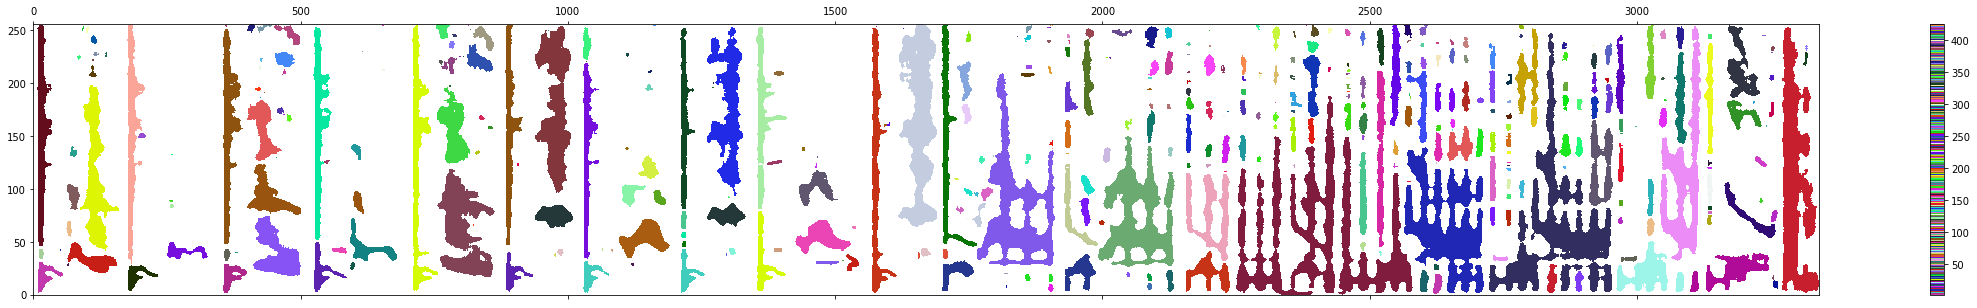

In [559]:
fig, ax = plt.subplots(figsize=figsize)
blob_copy = blobs.copy()
blob_copy[blob_copy == 0] = np.nan
plot_spec(blob_copy, fig = fig, ax=ax, cmap = cmap);

### Merge together clusters
- for each point, if that point is consumed by another, syllable by over some threshold, add this syllable to that syllable

In [560]:
# threshold for joining clusters that are overlapping
overlap_thresh = 0.8

In [561]:
# get unique points
unique_pts = np.unique(blobs[blobs != 0].astype(int))

# get the time coverage of each element
total_coverage = [np.sum(blobs == i, axis=0) for i in tqdm(unique_pts)]

# sort by the length of the element
size_sort = np.argsort(np.sum(np.array(total_coverage) >0, axis=1))

# rearrage based upon size
unique_pts = unique_pts[size_sort]
total_coverage = np.array(total_coverage)[size_sort]

print(len(unique_pts), np.shape(total_coverage))

for tci, (dp, tc) in tqdm(
    enumerate(zip(unique_pts, total_coverage)), total=len(unique_pts)
):
    # find where this syllable is
    tc_spot = np.where(tc > 0)[0]
    # find elements overlapping this element
    matching_cluster = np.where(
        (np.sum(total_coverage[tci + 1 :, tc_spot]  > 0, axis=1))
        > (len(tc_spot) * overlap_thresh)
    )[0]
    
    # if there are any, add this element to that group
    if len(matching_cluster) > 0:
        matching_cluster_id = unique_pts[matching_cluster[-1] + tci + 1]
        
        blobs[blobs == dp] = matching_cluster_id

426 (426, 3341)


In [562]:
unique_pts = np.unique(blobs[blobs != 0].astype(int))
len(unique_pts)

39

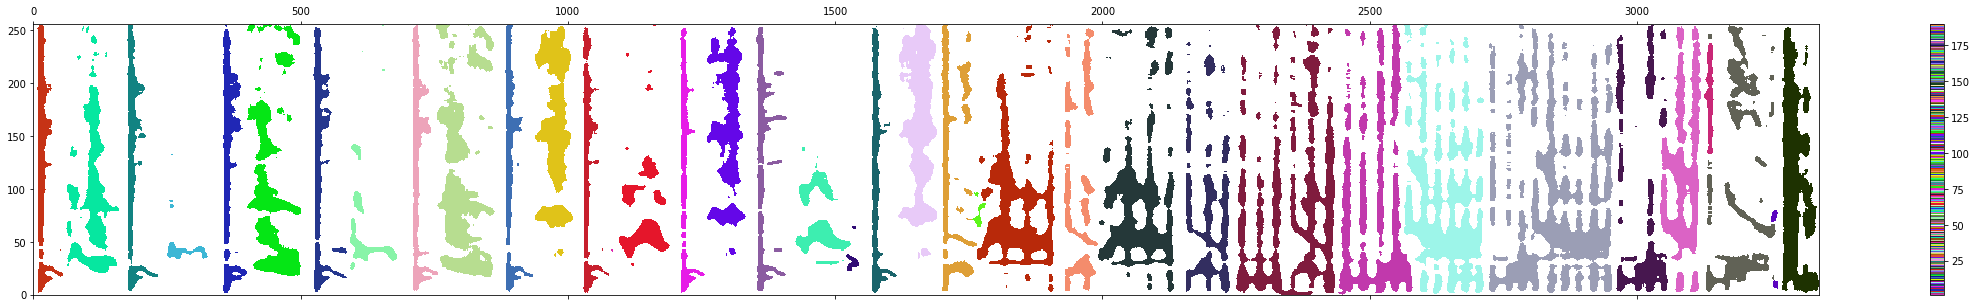

In [563]:
fig, ax = plt.subplots(figsize=figsize)
blob_copy = blobs.copy()
blob_copy[blob_copy == 0] = np.nan
plot_spec(blob_copy, fig = fig, ax=ax, cmap = cmap);

In [566]:
unique_pts = np.unique(blobs[blobs != 0].astype(int))
remap_dict = {dp:ndp for dp, ndp in zip(unique_pts, np.random.permutation(unique_pts))}
for k, v in remap_dict.items(): blobs[blobs==k] = v
unique_pts

array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  12,  13,  14,  18,
        21,  24,  25,  26,  37,  41,  42,  45,  48,  55,  59,  61,  65,
        74,  76,  84,  88,  99, 100, 101, 102, 110, 114, 121, 190])

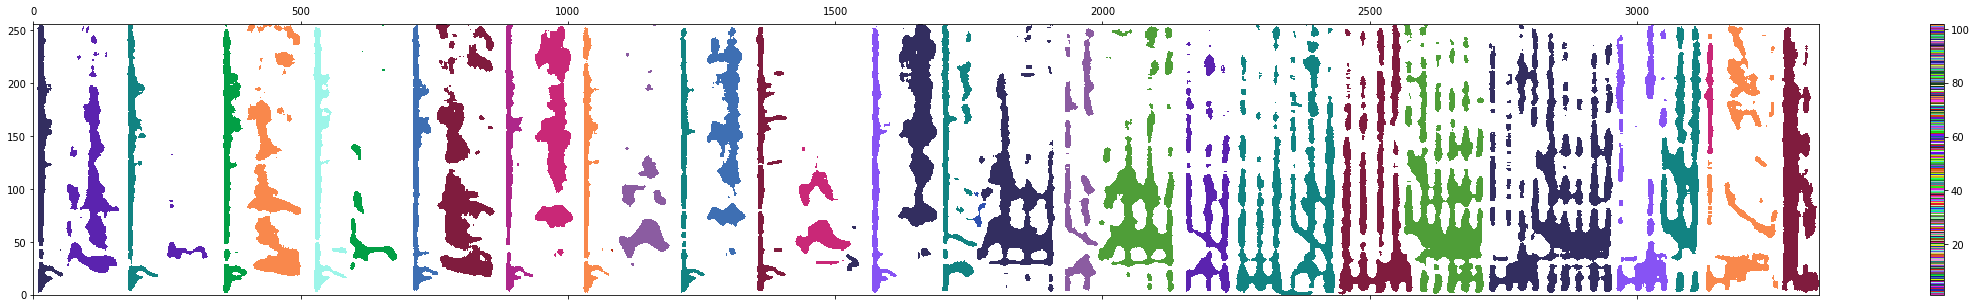

In [567]:
fig, ax = plt.subplots(figsize=figsize)
blob_copy = blobs.copy()
blob_copy[blob_copy == 0] = np.nan
plot_spec(blob_copy, fig = fig, ax=ax, cmap = cmap);

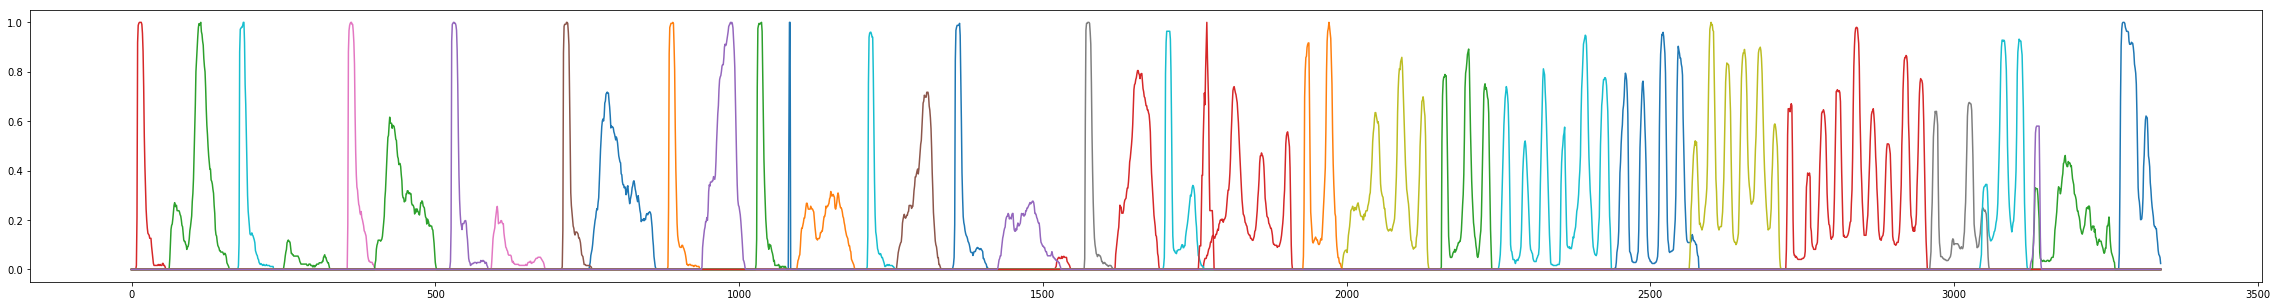

In [568]:
unique_pts = np.unique(blobs[blobs != 0].astype(int))

fig, ax = plt.subplots(figsize=figsize)
for i in unique_pts:
    ax.plot(norm(np.sum(blobs == i, axis=0)));

(0, 22047)

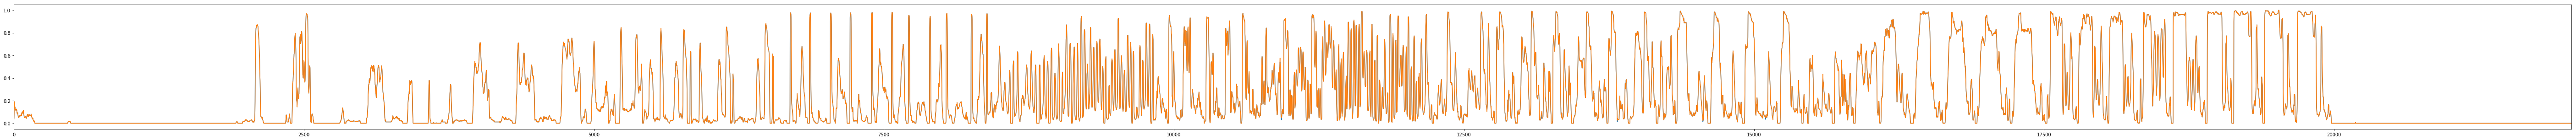

In [214]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(norm(np.max(total_coverage, axis=0)));
ax.plot(norm(np.sum(1-mask_mask, axis=0)));
ax.set_xlim([0,np.shape(total_coverage)[1]])

In [ ]:
mask[mask_mask] = 1

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(mask, fig = fig, ax=ax, cmap = plt.cm.Greys_r);

### smooth mask

In [ ]:
time_grad_ms = 2
freq_grad_hz = 100

In [ ]:
n_grad_freq = int(freq_grad_hz / ((rate/2) / np.shape(mask)[0]))
n_grad_time = int(hparams.hop_length_ms * time_grad_ms)
n_grad_freq, n_grad_time

In [ ]:
# Create a smoothing filter for the mask in time and frequency
smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

In [ ]:
fig, ax = plt.subplots()
ax.matshow(smoothing_filter, interpolation="none", aspect="auto", cmap=plt.cm.bone)

In [ ]:
sig_mask = scipy.signal.fftconvolve(mask.astype('float32'), smoothing_filter, mode="same")

In [ ]:
np.min(sig_mask), np.max(sig_mask)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(sig_mask, fig = fig, ax=ax, cmap = plt.cm.Greys_r);

### apply mask to data

In [ ]:
masked_sig = spec * (1-sig_mask)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(masked_sig, fig = fig, ax=ax, cmap = plt.cm.Greys);
#ax.plot(np.sum(masked_sig, axis=0)**.5, color='red')

In [ ]:
cmap2 = plt.cm.Greys
cmap2.set_bad(color=(0,0,0,0))

In [ ]:
masked_sig2 = masked_sig.copy()
masked_sig2[masked_sig2 < .2] = np.nan

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(blobs, fig = fig, ax=ax, cmap = cmap);
plot_spec(masked_sig2, fig = fig, ax=ax, cmap = cmap2);

In [ ]:
masked_sig

In [601]:
??plot_spec

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sum(norm(masked_sig), axis=0))
ax.set_xlim([0, np.shape(masked_sig)[1]])

In [ ]:
len(masked_sig)